### Multiclass Support Vector Machines
In this exercise you will:
- implement a fully-vectorized loss function for the mulri-class SVM
- implement the fully-vectorized expression for its analytic gradient
- check your implementation using numerical gradient
- use a validation set to tune the learning rate and regularization strength
- optimize the loss function with SGD
- visualize the final learned parameters

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### CIFAR-10 Data Loading and Preprocessing
Open up a terminal window and navigate to the datasets folder inside the hw3 folder. Run the get_datasets.sh script. On my Mac, I just type in ./get_datasets.sh at the shell prompt. A new folder called cifar_10_batches_py will be created and it will contain 50000 labeled images for training and  10000 labeled images for testing. The function further partitions the  50000 training images into a train set and a validation set for selection of hyperparameters. We have provided a function to read this data in **data_utils.py**. Each image is a  32×32
array of RGB triples. It is preprocessed by subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size 3072 (i.e.,  32×32×3). Then a 1 is appended to the front of that vector to handle the intercept term. So the training set is a numpy matrix of size  49000×3073, the validation set is a matrix of size  1000×3073 and the set-aside test set is of size  10000×3073. We also have a random sample of 500 images from the training data to serve as a development set or dev set to test our gradient and loss function implementations.

In [9]:
import data_utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_dev, y_dev, X_test, y_test = data_utils.get_CIFAR10_data()

Train data shape: 49000,32,32,3
Train labels shape: 49000
Validation data shape: 1000,32,32,3
Validation labels shape: 1000
Test data shape: 10000,32,32,3
Test labels shape: 10000
Dev data shape: 500,32,32,3
Test labels shape: 500
Training data shape: 49000,3072
Validation data shape: 1000,3072
Test data shape: 10000,3072
dev data shape: 500,3072
Training data shape with bias term: 49000,3073 
Validation data shape with bias term: 1000,3073
Test data shape with bias term: 10000,3073
Devset data shape with bias term: 500,3073


### SVM Classifier
Your code for this section will all be written inside **linear_svm.py**.
You will need to write the function **naive_loss_svm** which uses for loops to evaluate the multiclass SVM loss function.

In [29]:
# Evaluate the naive implementation of the loss we provided for you:
from linear_svm import svm_loss_naive
import time

# generate a random SVM coefficient matrix of small numbers
theta = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(theta, X_train, y_train, 0.00001)
print('loss: %f' % (loss, ))
print('grad: %s', grad)

loss: 9.092255
grad: %s [[-1.49315491e+01 -6.15482078e+00  4.67726880e+00 ... -4.72761833e+00
  -1.57009646e+01 -3.45804723e+01]
 [-2.57719514e+01 -2.27910772e+00  3.98397418e+00 ... -5.93194930e+00
  -2.65116086e+01 -3.91312759e+01]
 [-4.63165136e+01 -3.37770208e+00  1.59721338e+01 ... -5.61643781e+00
  -4.54470051e+01 -4.97392033e+01]
 ...
 [-1.01214558e+01 -5.45782043e+00 -6.67374450e-01 ... -9.76586176e+00
   1.55140051e+01 -9.05372157e+00]
 [-2.32613038e+01 -1.20490213e+01  6.89767455e+00 ...  5.13301343e+00
  -3.56463330e+00 -1.27484159e+01]
 [-4.04081528e-03  7.51020421e-03 -7.00000019e-03 ...  2.77550984e-03
   8.02040818e-03  1.05918356e-02]]


The grad returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function **svm_loss_naive**. You will find it helpful to interleave your new code inside the existing function.
To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you.

In [30]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at theta.
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda th: svm_loss_naive(th, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(theta, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

numerical: -14.137850 analytic: -14.137850, relative error: 1.410226e-11
numerical: 21.932886 analytic: 21.932886, relative error: 7.975951e-12
numerical: -11.246153 analytic: -11.246153, relative error: 1.494490e-11
numerical: -9.576372 analytic: -9.576372, relative error: 1.488086e-11
numerical: -23.418311 analytic: -23.418311, relative error: 6.699366e-13
numerical: 13.025603 analytic: 13.025603, relative error: 2.865428e-12
numerical: 1.580945 analytic: 1.580945, relative error: 5.995868e-11
numerical: -5.272969 analytic: -5.272969, relative error: 3.582380e-12
numerical: 9.563959 analytic: 9.563959, relative error: 1.627127e-12
numerical: -45.779440 analytic: -45.779440, relative error: 2.012375e-12
numerical: 18.038169 analytic: 18.038169, relative error: 9.096973e-12
numerical: -23.670339 analytic: -23.670339, relative error: 2.226005e-12
numerical: 20.491127 analytic: 20.491127, relative error: 6.561496e-12
numerical: -17.875271 analytic: -17.875271, relative error: 2.037190e-1

In [36]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('Difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.236604e+00 computed in 0.049906s
Vectorized loss: 9.236604e+00 computed in 0.003978s
Difference: 0.000000


### Vectorized version of the gradient computation
Complete the implementation of svm_loss_vectorized, and compute the gradient
of the loss function in a vectorized way.



In [37]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Difference: %f' % difference)

Naive loss and gradient: computed in 0.048185s
Vectorized loss and gradient: computed in 0.006001s
Difference: 0.000000


In [38]:
# In the file linear_classifier.py, we have implemented SGD in the function
# LinearClassifier.train() and you can run it with the code below.
from linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 790.492486
iteration 100 / 1500: loss 286.534760
iteration 200 / 1500: loss 107.267132
iteration 300 / 1500: loss 42.254545
iteration 400 / 1500: loss 19.094091
iteration 500 / 1500: loss 10.384855
iteration 600 / 1500: loss 6.915063
iteration 700 / 1500: loss 5.863477
iteration 800 / 1500: loss 5.470280
iteration 900 / 1500: loss 5.015008
iteration 1000 / 1500: loss 5.419287
iteration 1100 / 1500: loss 5.114128
iteration 1200 / 1500: loss 5.593335
iteration 1300 / 1500: loss 5.488801
iteration 1400 / 1500: loss 5.311691
That took 6.488402s


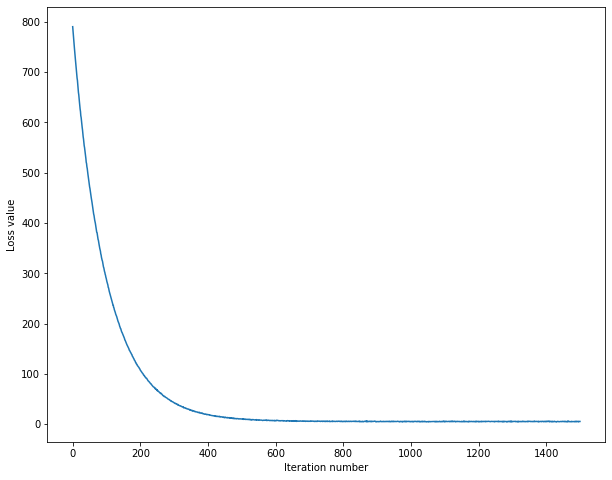

In [39]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Prediction with an SVM
Compute $\theta^T  x$ for a new example $x$ and pick the class with the highest score.

In [40]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.363429
validation accuracy: 0.371000


In [43]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.38 or higher on the validation set.

learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [1e4, 5e4, 1e5, 5e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm_clf = LinearSVM()
        loss_hist = svm_clf.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=False)
        y_train_pred = svm_clf.predict(X_train)
        train_acc = np.mean(y_train_pred)
        y_val_pred = svm_clf.predict(X_val)
        val_acc = np.mean(y_val_pred)

        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm_clf

        results[(lr, reg)] = (train_acc, val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


iteration 0 / 1500: loss 179.317399
iteration 100 / 1500: loss 169.222382
iteration 200 / 1500: loss 163.792551
iteration 300 / 1500: loss 158.887202
iteration 400 / 1500: loss 156.320340
iteration 500 / 1500: loss 152.273398
iteration 600 / 1500: loss 148.878565
iteration 700 / 1500: loss 145.588648
iteration 800 / 1500: loss 140.470026
iteration 900 / 1500: loss 138.471635
iteration 1000 / 1500: loss 135.742870
iteration 1100 / 1500: loss 134.673119
iteration 1200 / 1500: loss 130.254898
iteration 1300 / 1500: loss 127.840459
iteration 1400 / 1500: loss 124.197573
iteration 0 / 1500: loss 784.043089
iteration 100 / 1500: loss 704.394852
iteration 200 / 1500: loss 636.828098
iteration 300 / 1500: loss 575.140944
iteration 400 / 1500: loss 518.513745
iteration 500 / 1500: loss 469.693750
iteration 600 / 1500: loss 424.693381
iteration 700 / 1500: loss 383.627285
iteration 800 / 1500: loss 348.270926
iteration 900 / 1500: loss 313.510498
iteration 1000 / 1500: loss 286.177157
iteration 

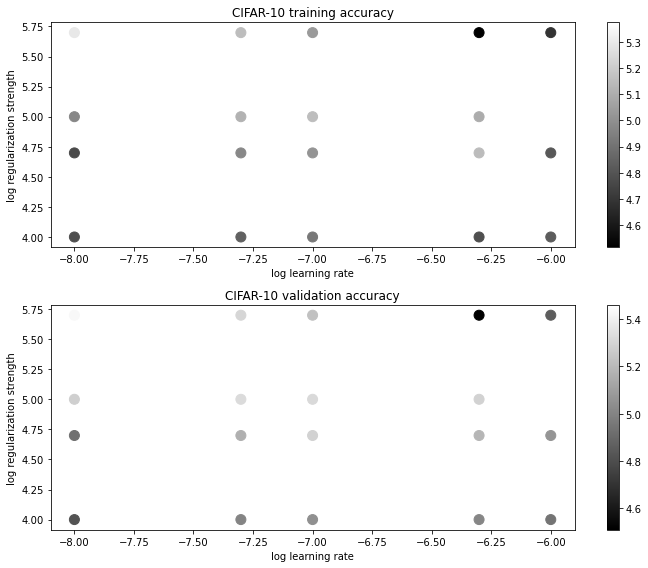

In [47]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
# plt.savefig("tuning_with_validation_train_acc")

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout()
plt.savefig("tuning_with_validation_val_acc")

plt.show()



In [48]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.263600


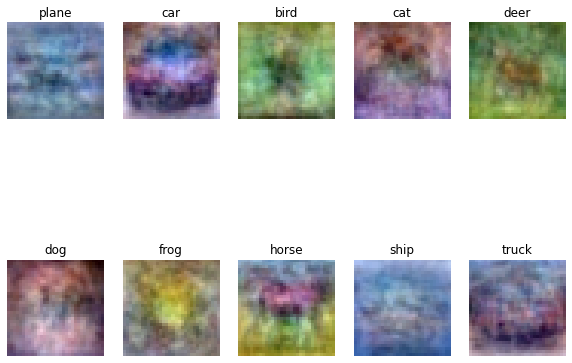

In [49]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.

theta = best_svm.theta[:-1,:] # strip out the bias
theta = theta.reshape(32, 32, 3, 10)
theta_min, theta_max = np.min(theta), np.max(theta)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[:, :, :, i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])